# 5. laboratorijska vježba
### TBA
https://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Tutorial.html

http://www.scholarpedia.org/article/Ion_channels#Bioelectricity_results_from_currents_in_ion_channels

https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#Voltage-gated_ion_channels

<img src="static/hodgkin-huxley-model.svg" alt="hodgkin-huxley-model" width="400"/>
<center>Izvor <a href="https://github.com/openworm/hodgkin_huxley_tutorial/blob/master/Tutorial/_static/Electrophysiology.rst">OpenWorm</center>


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [57]:
class HodgkinHuxley(object):
    """Full Hodgkin-Huxley Model implementation.
    Original implementation: 
    https://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Hodgkin%20Huxley.html
    """
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L):
        """Constructor.
        
        Parameters
        ----------
        C_m : float
            Membrane capacitance [F/cm^2]
        g_Na : float
            Sodium (Na) maximum conductances [mS/cm^2]
        g_K : float
            Postassium (K) maximum conductances [mS/cm^2]
        g_L : float
            Leak maximum conductances [mS/cm^2]
        E_Na : float
            Sodium (Na) Nernst reversal potentials [mV]
        E_K : float
            Postassium (K) Nernst reversal potentials [mV]
        E_L : float
            Leak Nernst reversal potentials [mV]
        
        Returns
        -------
        None
        """
        self.C_m = C_m 
        self.g_Na = g_Na
        self.g_K  = g_K 
        self.g_L  = g_L 
        self.E_Na = E_Na
        self.E_K = E_K 
        self.E_L = E_L 

    def alpha_m(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Return the value of membrane voltage.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Overall membrane voltage [mV]
        """
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """Return the value of Na membrane current.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Na membrane current density [uA/cm^2]
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """Return the value of K membrane current.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            K membrane current density [uA/cm^2]
        """
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        """Return the value of leak current.
        
        Parameters
        ----------
        V : float
            Membrane potential [mV]
            
        Returns
        -------
        float
            Leak current density [uA/cm^2]
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """Return the external current values over simulation time, `t`.
        
        Parameters
        ----------
        t : float
            Simulation time point
            
        Returns
        -------
        numpy.ndarray
            External current density [uA/cm^2]:
            step up to 10 uA/cm^2 at t>100
            step down to 0 uA/cm^2 at t>200
            step up to 35 uA/cm^2 at t>300
            step down to 0 uA/cm^2 at t>400
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)

    def ode_system(self, initial_conds, t):
        """Hodgkin Huxley model based on a set of four coupled ODEs.
        For details, go here: https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#Voltage-gated_ion_channels

        Parameters
        ----------
        initial_conds : list
            Initial conditions for membrane potential and m, h and n activation variables
            
        t : numpy.ndarray
            A sequence of time points for which to solve for y
            
        Returns
        -------
        tuple
            Membrane potential and m, h adn n activation variables
        """
        V, m, h, n = initial_conds

        dVdt = (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return (dVdt, dmdt, dhdt, dndt)
    
    def simulate(self, initial_conds, t):
        self.t = t
        sol = odeint(self.ode_system, initial_conds, self.t)
        V = sol[:, 0]
        m = sol[:, 1]
        h = sol[:, 2]
        n = sol[:, 3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
        iinj = [self.I_inj(t) for t in self.t]
        
        fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(8, 10))
        ax[0].plot(self.t, V)
        ax[0].set_xlabel('$t$ [ms]')
        ax[0].set_ylabel('$V$ [mV]')
        ax[0].grid()
        
        ax[1].plot(self.t, ina, label='$I_{Na}$')
        ax[1].plot(self.t, ik, label='$I_{K}$')
        ax[1].plot(self.t, il, label='$I_{L}$')
        ax[1].set_xlabel('$t$ [ms]')
        ax[1].set_ylabel('$I$ [$\\mu$A]')
        ax[1].legend()
        ax[1].grid()

        ax[2].plot(self.t, m, label='$m$')
        ax[2].plot(self.t, h, label='$h$')
        ax[2].plot(self.t, n, label='$n$')
        ax[2].set_xlabel('$t$ [ms]')
        ax[2].set_ylabel('Gating activation')
        ax[2].legend()
        ax[2].grid()

        ax[3].plot(self.t, iinj)
        ax[3].set_xlabel('$t$ [ms]')
        ax[3].set_ylabel('$I_{inj}$ [$\\mu$A $\cdot$ $cm^{-2}$]')
        ax[3].set_ylim(-1, 40)
        ax[3].grid()
        
        plt.tight_layout()
        plt.show()

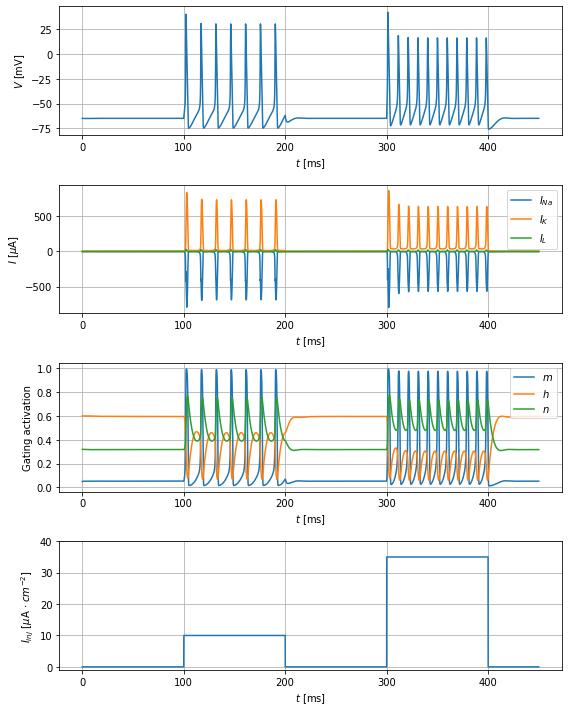

In [58]:
C_m = 1.0  # membrane capacitance [F/cm^2]
g_Na = 120.0  # Sodium (Na) maximum conductances [mS/cm^2]
g_K  = 36.0  # Postassium (K) maximum conductances [mS/cm^2]
g_L  = 0.3  # Leak maximum conductances [mS/cm^2]
E_Na = 50.0  # Sodium (Na) Nernst reversal potentials [mV]
E_K  = -77.0  # Postassium (K) Nernst reversal potentials [mV]
E_L  = -54.387  # Leak Nernst reversal potentials [mV]

initial_conds = [-65, 0.05, 0.6, 0.32]
t = np.arange(0.0, 450.0, 0.01)  # simulation time [ms]

model = HodgkinHuxley(C_m, g_Na, g_K, g_L, E_Na, E_K, E_L)
model.simulate(initial_conds, t)